# Welcome to my tutorial

Hello researcher! I'm Benji Metha, one of the developers/testers for Lenstronomy's tracer module. In this Notebook, I will show you how lenstronomy can be used to fit a metallicity profile to observed galaxy data. 

To make it work, you need three things:

* Observations of the light distribution of the system (It's also fine to use a bright emission line, such as H$\alpha$).
* Observations of the 2D metallicity distribution of the system, with uncertainty.
* An estimate of the point spread function of the telescope.

This approach offers two benefits over a traditional approach: Firstly, it corrects for the effects of PSF smearing. Secondly, it allows asymmetric models to be fit to metallicity profiles that do not appear to be radially symmetric.

For the mathematical details, and to cite this module, see [this paper](href to Arxiv). This document roughly follows the layout of that paper so you can read along.

For other tutorials on lenstronomy, including information about how to change the numerical methods, use more complicated PSFs, or account for gravitational lensing, see [Simon's notebooks](https://github.com/lenstronomy/lenstronomy-tutorials).

## Installing lenstronomy

`lenstronomy` can be installed by simply using pip: `pip install lenstronomy`. 

**THIS CURRENTLY DOES NOT GIVE THE USER THE TRACER MODEL. NEEDS TO BE ADDED, OR NEED DIFFERENT INSTRUCTIONS FOR GETTING THIS MODULE.**

For this tutorial, you will also need the following packages: `statsmodels` for the first part, and `webbpsf` for the second. `statsmodels` can be installed via pip:

`python -m pip install statsmodels`  

For `webbpsf`, things are a little more compicated, as you also need to download a folder of data files and set up a path to it. See the instructions on [their website](https://webbpsf.readthedocs.io/en/stable/installation.html).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import webbpsf
from statsmodels.regression.linear_model import WLS

import lenstronomy
from lenstronomy.Data.psf import PSF
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.Util import util
from lenstronomy.Util import image_util
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.ImSim.tracer_model import TracerModelSource
from lenstronomy.Workflow.fitting_sequence import FittingSequence

**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-062 CANNOT BE CHECKED AGAINST ONLINE VERSION
/Users/ben/anaconda3/lib/python3.11/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)


## Use case #1: Forward-modelling the effects of psf smear

[Acharyya+20](https://ui.adsabs.harvard.edu/abs/2020MNRAS.495.3819A/abstract) (and others) showed that when the size of a PSF becomes comparable to the scale radius of a galaxy, the metallicity gradients recovered using standard techniques were biased to recover flatter values for the metallicity gradient. Luckily, with forward modelling, we can correct for this effect!

First, we simulate a galaxy:

In [6]:
supersampling_factor = 5
kwargs_numerics = {'supersampling_factor':supersampling_factor, 'point_source_supersampling_factor':supersampling_factor, 'supersampling_convolution': True}

# imaging data specifics
numPix      = 121    # for 8'' x 8'' cutout of NIRISS
pixel_scale = 0.066  #  pixel size in arcsec

# Sersic parameters in the initial simulation for the source
kwargs_sersic = {'amp': 16, 'R_sersic': 1, 'n_sersic': 1, 'e1': 0, 'e2': 0, 'center_x': 0, 'center_y': 0}
source_model_list = ['SERSIC_ELLIPSE']
kwargs_source = [kwargs_sersic]
source_model_class = LightModel(source_model_list)

# Source tracer model 1 -- linear gradient
tracer_source_model_list = ['LINEAR']
kwargs_tracer_source = [{'amp': 8, 'k': -0.2, 'center_x': kwargs_sersic['center_x'], 'center_y': kwargs_sersic['center_y']}]
tracer_source_class = LightModel(tracer_source_model_list)

###  Make mock light data class

# generate the coordinate grid and image properties (we only read out the relevant lines we need)
_, _, ra_at_xy_0, dec_at_xy_0, _, _, Mpix2coord, _ = util.make_grid_with_coordtransform(numPix=numPix, deltapix=pixel_scale, center_ra=0, center_dec=0, subgrid_res=1, inverse=False)


kwargs_image_data = {'background_rms':.005 ,  # rms of background noise; background noise per pixel
               'exposure_time': 500.,  # exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
               'ra_at_xy_0': ra_at_xy_0,  # RA at (0,0) pixel
               'dec_at_xy_0': dec_at_xy_0,  # DEC at (0,0) pixel 
               'transform_pix2angle': Mpix2coord,  # matrix to translate shift in pixel in shift in relative RA/DEC (2x2 matrix). Make sure it's units are arcseconds or the angular units you want to model.
               'image_data': np.zeros((numPix, numPix))  # 2d data vector, here initialized with zeros as place holders that gets overwritten once a simulated image with noise is created.
              }

image_data_class = ImageData(**kwargs_image_data)

# constants for heteroskedastic noise
c2 = 0.00091
c1 = 0.00725

# Make PSF class. 
# I encourage you to experiment with changing the FWHM!
FWHM                 = 1.5
psf_type             = 'GAUSSIAN'
psf_truncation       = 4 # four sigma is plenty

kwargs_psf = {'psf_type': psf_type, 'fwhm': FWHM, 'pixel_size': pixel_scale, 'truncation': psf_truncation}
psf_class = PSF(**kwargs_psf)

# Generate a photometric image
imageModel = ImageModel(image_data_class, psf_class,
						source_model_class=source_model_class,
						kwargs_numerics=kwargs_numerics)

image_model = imageModel.image(kwargs_source=kwargs_source)

# Use this image to compute heteroskedastic noise based on brightness.
heteronoise_var_map = c1 + c2/image_model
heteronoise_SD_map  = np.sqrt(heteronoise_var_map)

# Generate a metallicity map
kwargs_tracer_data = {'noise_map': heteronoise_SD_map, # S.D. of pixels
                      'ra_at_xy_0': ra_at_xy_0,  # RA at (0,0) pixel
                      'dec_at_xy_0': dec_at_xy_0,  # DEC at (0,0) pixel 
                      'transform_pix2angle': Mpix2coord,  # matrix to translate shift in pixel in shift in relative RA/DEC (2x2 matrix). Make sure it's units are arcseconds or the angular units you want to model.
                      'image_data': np.zeros((numPix, numPix))  # 2d data vector, here initialized with zeros as place holders that get's overwritten once a simulated image with noise is created.
                      }

tracer_data_class = ImageData(**kwargs_tracer_data)

tracer_model_class = TracerModelSource(data_class=tracer_data_class,
									   tracer_source_class=tracer_source_class,
									   psf_class=psf_class,
									   source_model_class=source_model_class,
									   tracer_type = 'METALLICITY')

tracer_model = tracer_model_class.tracer_model(kwargs_lens = None, kwargs_tracer_source=kwargs_tracer_source, kwargs_source=kwargs_source)

# add noise to metallicity data
tracer_noise = image_util.add_background(image_model, sigma_bkd=heteronoise_SD_map)
tracer_real = tracer_model + tracer_noise


We can visualise this galaxy's image and metallicity map:

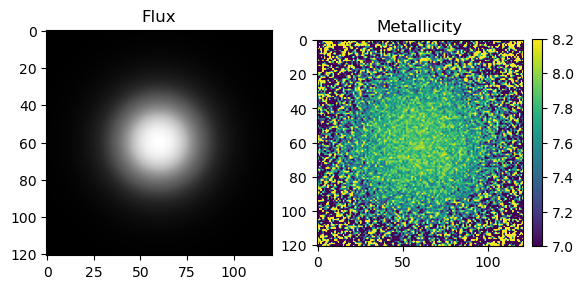

In [24]:
fig, axes = plt.subplots(1,2)
axes[0].imshow(image_model, cmap='Greys_r')
axes[0].set_title("Flux")
z_plot = axes[1].imshow(tracer_real, vmin=7, vmax=8.2)
axes[1].set_title("Metallicity")
plt.colorbar(z_plot,ax=axes[1],fraction=0.046, pad=0.04)

We can attempt to fit the metallicity gradient for this galaxy using weighted least squares (WLS) and the observed metallicity profile, but it won't be correct:

In [38]:
# First, find the radial distance from each pixel to the galaxy's center
x        = np.arange(numPix)
y        = np.arange(numPix)
X, Y     = np.meshgrid(x, y)
gal_cen  = (numPix - 1)/2
R_pix    = np.sqrt( (X - gal_cen)**2 + (Y - gal_cen)**2 )
R_arcsec = R_pix * pixel_scale

# Using this, construct the covariate matrix for a linear model
flat_R     = R_arcsec.flatten()
ones       = np.ones(len(flat_R))
covariates = np.vstack((ones, flat_R)).T

# Weight each pixel by the inverse variance of the measured metallicity
weights      = heteronoise_var_map**(-1)
flat_weights = weights.flatten()

# Fit a model
wls_model_fit = WLS(tracer_real.flatten(), covariates, weights=flat_weights).fit()

print(wls_model_fit.summary())

print("\nRecovered Zc = {0:.5}, gradZ = {1:.5}.".format(*wls_model_fit.params))
print("True      Zc = 8.0,    gradZ = -0.2.")

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.138
Model:                            WLS   Adj. R-squared:                  0.138
Method:                 Least Squares   F-statistic:                     2349.
Date:                Fri, 13 Oct 2023   Prob (F-statistic):               0.00
Time:                        13:42:41   Log-Likelihood:                -11946.
No. Observations:               14641   AIC:                         2.390e+04
Df Residuals:                   14639   BIC:                         2.391e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.9873      0.005   1479.267      0.0

On the other hand, we can fit the metallicity gradient using forward-modelling with `lenstronomy`'s tracer module, for a much more accurate result:  
(expected run time: ~5 minutes. Make yourself a cup of tea!)

In [52]:
# Setup numerics for adaptive supersampling within 2Re, where there is the most signal,
# without supersampling regions where there is not much light for computational efficiency

supersampling_R_pix = 30 #pixels, = 2'', which is 2Re
pix_to_supersample = R_pix < supersampling_R_pix

kwargs_numerics_adaptive_supersampling = {'supersampling_factor':supersampling_factor,
                        'point_source_supersampling_factor':supersampling_factor,
                        'compute_mode': 'adaptive',
                        'supersampling_convolution': False,  
                        'supersampling_kernel_size': None,
                        'supersampled_indexes': pix_to_supersample}

# Define the parameter lists (long, but not complex)

# lens models
# Since our model is no lens, use a bunch of empty lists
fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []
lens_params = [kwargs_lens_init, kwargs_lens_sigma, fixed_lens, kwargs_lower_lens, kwargs_upper_lens]

# Source params -- fixed to true input values
# We know that lenstronomy can fit galaxy properties, we are not testing this here.
fixed_source        = [{'amp': 16, 'R_sersic': 1, 'n_sersic': 1, 'e1': 0, 'e2': 0, 'center_x': 0, 'center_y': 0}]
kwargs_source_init  = [{'amp': 16, 'R_sersic': 1, 'n_sersic': 1, 'e1': 0, 'e2': 0, 'center_x': 0, 'center_y': 0}]
kwargs_source_sigma = [{'amp': 1, 'R_sersic': 1, 'n_sersic': 1, 'e1': 1, 'e2': 1, 'center_x': 1, 'center_y': 1}]
kwargs_lower_source = [{'amp': 16, 'R_sersic': 1, 'n_sersic': 1, 'e1': 0, 'e2': 0, 'center_x': 0, 'center_y': 0}]
kwargs_upper_source = [{'amp': 16, 'R_sersic': 1, 'n_sersic': 1, 'e1': 0, 'e2': 0, 'center_x': 0, 'center_y': 0}]

source_params = [kwargs_source_init, kwargs_source_sigma, fixed_source, kwargs_lower_source, kwargs_upper_source]

# Tracer params
fixed_tracer_source = [{'center_x': 0., 'center_y': 0}]
# close but wrong initial Zc, model assumes no metallicity gradient
kwargs_tracer_source_init = [{'center_x': 0., 'center_y': 0, 'amp': 7.9, 'k': 0}] 
kwargs_tracer_source_sigma = [{'center_x': 1., 'center_y': 1., 'amp': 0.5, 'k': 0.3}]
kwargs_lower_tracer_source = [{'center_x': 0., 'center_y': 0, 'amp': 6, 'k': -1}]
kwargs_upper_tracer_source = [{'center_x': 0., 'center_y': 0, 'amp': 9, 'k': +1}]

tracer_source_params = [kwargs_tracer_source_init, kwargs_tracer_source_sigma, fixed_tracer_source, kwargs_lower_tracer_source, kwargs_upper_tracer_source]

# Bring it together
kwargs_params = {'lens_model': lens_params,
                'source_model': source_params,
                'tracer_source_model': tracer_source_params}
                
kwargs_likelihood = {'source_marg': False, 'tracer_likelihood': True}

kwargs_model = {'lens_model_list': [], 
                'source_light_model_list': ['SERSIC_ELLIPSE'], 
                'tracer_source_model_list': ['LINEAR'],
                'tracer_source_band': 0,
                'tracer_partition':[[0,0]]
                }

# Input the observed light map
kwargs_image_data['image_data'] = image_model # Overwrite placeholder of zeros
image_data_class = ImageData(**kwargs_image_data)

# Input the observed metallicity map and its noise
kwargs_tracer_data['noise_map'] =  heteronoise_SD_map # S.D. of pixels
kwargs_tracer_data['image_data']= tracer_real         # Overwrite placeholder of zeros   
tracer_data_class = ImageData(**kwargs_tracer_data)

# Now we can start fitting, using the kwargs defined above on the simulated data
multi_band_list = [[kwargs_image_data, kwargs_psf, kwargs_numerics_adaptive_supersampling]]

kwargs_data_joint = {'multi_band_list': multi_band_list, 
					 'multi_band_type': 'single-band',  # 'multi-linear': every imaging band has independent solutions of the surface brightness, 'joint-linear': there is one joint solution of the linear coefficients demanded across the bands.
					 'tracer_data': [kwargs_tracer_data, kwargs_psf, kwargs_numerics_adaptive_supersampling],
					}

kwargs_constraints = {'linear_solver': True}

fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params)

fitting_kwargs_list = [['PSO',  {'sigma_scale': 1, 'n_particles': 100, 'n_iterations': 100}],
                       ['MCMC', {'n_burn': 50, 'n_run': 200, 'n_walkers': 100, 'sigma_scale': .1}]]

chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()

print(kwargs_result)

Computing the PSO ...
10
20
30
40
50
60
70
Converged after 74 iterations!
Best fit found:  -7332.310942648227 [8.00574890167883, -0.19412443625947493]
-0.5008580171896736 reduced X^2 of best position
-7332.310942648227 log likelihood
29279.0 effective number of data points
[] lens result
[{'amp': 16, 'R_sersic': 1, 'n_sersic': 1, 'e1': 0, 'e2': 0, 'center_x': 0, 'center_y': 0}] source result
[] lens light result
[] point source result
[{'amp': 8.00574890167883, 'k': -0.19412443625947493, 'center_x': 0.0, 'center_y': 0}] tracer source result
{} special param result
92.56888794898987 time used for  PSO


100%|█████████████████████████████████████████| 250/250 [04:55<00:00,  1.18s/it]

Computing the MCMC...
Number of walkers =  100
Burn-in iterations:  50
Sampling iterations (in current run): 250
296.3597400188446 time taken for MCMC sampling
{'kwargs_lens': [], 'kwargs_source': [{'amp': 16, 'R_sersic': 1, 'n_sersic': 1, 'e1': 0, 'e2': 0, 'center_x': 0, 'center_y': 0}], 'kwargs_lens_light': [], 'kwargs_ps': [], 'kwargs_special': {}, 'kwargs_extinction': [], 'kwargs_tracer_source': [{'amp': 8.005745088625286, 'k': -0.19411408807582153, 'center_x': 0.0, 'center_y': 0}]}


Much better! From the posteriors of our emcee chain we can get credible intervals and formal uncertainties on these fitted parameters, too:

In [63]:
sampler_type, samples_mcmc, param_mcmc, dist_mcmc  = chain_list[1]

lower_bound = np.percentile(samples_mcmc[:,1], 16)
median      = np.percentile(samples_mcmc[:,1], 50)
upper_bound = np.percentile(samples_mcmc[:,1], 84)

print("gradZ = {0:.4} (+{1:.4}/-{2:.4})".format(median, upper_bound - median, median-lower_bound))

gradZ = -0.1939 (+0.003864/-0.003863)


## Use case #2: Fitting more flexible models

Most galaxies at cosmic noon are not disk galaxies, and do not show a well-established metallicity gradient. To understand these systems, we must use models that can capture asymmetric chemical structure.

To demonstrate how `lenstronomy` can perform these fits, we simulate a clumpy galaxy made of three smaller Sersic sub-systems: 

In [31]:
supersampling_factor = 5
kwargs_numerics = {'supersampling_factor':supersampling_factor, 'point_source_supersampling_factor':supersampling_factor, 'supersampling_convolution': True}

# Make a realistic NIRISS psf from webbpsf, supersampled by a factor of 5
niriss        = webbpsf.NIRISS()
niriss.filter = 'F150W'
psf           = niriss.calc_psf(fov_arcsec=1, oversample=supersampling_factor)

psf_array  = psf[0].data
psf_type   = 'PIXEL'
kwargs_psf = {'psf_type': psf_type, 'kernel_point_source':psf_array, 'point_source_supersampling_factor':supersampling_factor}
psf_class  = PSF(**kwargs_psf)

# imaging data specifics
numPix      = 31    # for 2'' x 2'' cutout of NIRISS
pixel_scale = 0.066  #  pixel size in arcsec

# Define the light map for the clumpy system
delta_pos = 0.25

kwargs_sersic1 = {'amp': 16, 'R_sersic': 0.25, 'n_sersic': 1, 'e1': 0, 'e2': 0, 'center_x': 0, 'center_y': 0}
kwargs_sersic2 = {'amp': 16, 'R_sersic': 0.25, 'n_sersic': 1, 'e1': 0, 'e2': 0, 'center_x': delta_pos, 'center_y': 0}
kwargs_sersic3 = {'amp': 16, 'R_sersic': 0.25, 'n_sersic': 1, 'e1': 0, 'e2': 0, 'center_x': -delta_pos, 'center_y': -delta_pos}
source_model_list = ['SERSIC_ELLIPSE', 'SERSIC_ELLIPSE', 'SERSIC_ELLIPSE']
kwargs_source = [kwargs_sersic1, kwargs_sersic2, kwargs_sersic3]
source_model_class = LightModel(source_model_list)

# Make mock light data
# generate the coordinate grid and image properties (we only read out the relevant lines we need)
_, _, ra_at_xy_0, dec_at_xy_0, _, _, Mpix2coord, _ = util.make_grid_with_coordtransform(numPix=numPix, deltapix=pixel_scale, center_ra=0, center_dec=0, subgrid_res=1, inverse=False)



kwargs_image_data = {'background_rms':.005 ,  # rms of background noise; background noise per pixel
               'exposure_time': 500.,  # exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
               'ra_at_xy_0': ra_at_xy_0,  # RA at (0,0) pixel
               'dec_at_xy_0': dec_at_xy_0,  # DEC at (0,0) pixel 
               'transform_pix2angle': Mpix2coord,  # matrix to translate shift in pixel in shift in relative RA/DEC (2x2 matrix). Make sure it's units are arcseconds or the angular units you want to model.
               'image_data': np.zeros((numPix, numPix))  # 2d data vector, here initialized with zeros as place holders that get's overwritten once a simulated image with noise is created.
              }

image_data_class = ImageData(**kwargs_image_data)

imageModel = ImageModel(image_data_class, psf_class,
                        source_model_class=source_model_class,
                        kwargs_numerics=kwargs_numerics)
                        
image_model = imageModel.image(kwargs_source=kwargs_source)

# Make a heteroskedastic noise map for the metallicity, so that the brightest
# regions have the least uncertain metallicities.
c1 = 0.005
c2 = 0.0015

heteronoise_var_map = c1 + c2/image_model
heteronoise_SD_map  = np.sqrt(heteronoise_var_map)

# Define a compound metallicity model, using a different constant metallicity for each component of the system.
tracer_source_model_list = ['LINEAR', 'LINEAR', 'LINEAR']
kwargs_z1 = {'amp': 7.6,
			  'k': 0, 'center_x': kwargs_sersic1['center_x'], 'center_y': kwargs_sersic1['center_y']}
kwargs_z2 = {'amp': 7.8, 
			  'k': 0, 'center_x': kwargs_sersic2['center_x'], 'center_y': kwargs_sersic2['center_y']}
kwargs_z3 = {'amp': 7.9, 
			  'k': 0, 'center_x': kwargs_sersic3['center_x'], 'center_y': kwargs_sersic3['center_y']}
kwargs_tracer = [kwargs_z1, kwargs_z2, kwargs_z3]
tracer_source_class = LightModel(tracer_source_model_list)

kwargs_tracer_data = {'noise_map': heteronoise_SD_map, # S.D. of pixels
               'ra_at_xy_0': ra_at_xy_0,  # RA at (0,0) pixel
               'dec_at_xy_0': dec_at_xy_0,  # DEC at (0,0) pixel 
               'transform_pix2angle': Mpix2coord,  # matrix to translate shift in pixel in shift in relative RA/DEC (2x2 matrix). Make sure it's units are arcseconds or the angular units you want to model.
               'image_data': np.zeros((numPix, numPix))  # 2d data vector, here initialized with zeros as place holders that get's overwritten once a simulated image with noise is created.
              }

tracer_data_class = ImageData(**kwargs_tracer_data)

tracer_model_class = TracerModelSource(data_class=tracer_data_class,
                                       tracer_source_class=tracer_source_class,
                                       psf_class=psf_class,
# This next line defines which metallicity component traces which light component.
                                       tracer_partition = [ [0,0], [1,1], [2,2] ],
# If tracer_type = METALLICITY, we account for the fact that the metallicity is a log-quantity
# when adding light from different components.
# Use tracer_type = LINEAR if you are looking at a linear quantity that is traced by light
# (e.g. velocity, color, or light-weighted average stellar age in each pixel).
                                       tracer_type = 'METALLICITY',
                                       source_model_class=source_model_class,
                                       kwargs_numerics=kwargs_numerics)

tracer_model = tracer_model_class.tracer_model(kwargs_lens = None, kwargs_tracer_source=kwargs_tracer, kwargs_source=kwargs_source)

Again, we can visualise the light profile and metallicity distribution for this galaxy. For clarity, we show the fit with and without noise, as the signal is too small to see by human eye. Note that when we use lenstronomy for the fit, we are comparing against the noisy version.

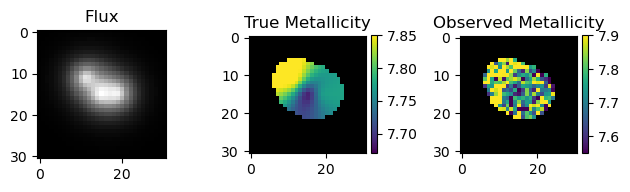

In [35]:
fig, axes = plt.subplots(1,3)
axes[0].imshow(image_model, cmap='Greys_r')
axes[0].set_title("Flux")

# Technically, the map we constructed extends infinitely in space.
# But it should only be valid within the galaxy; so we make a mask to make our 
# map more clear.
# You can raise this value if you want to extend the model out further.
out_of_mask = heteronoise_SD_map > 0.2
Z_map = np.array(tracer_model)
Z_map[out_of_mask] = np.nan

axes[1].set_facecolor('black')
z_plot = axes[1].imshow(Z_map, vmin=7.67, vmax=7.85)
axes[1].set_title("True Metallicity")
plt.colorbar(z_plot, ax=axes[1], fraction=0.046, pad=0.04)

obs_Z = Z_map + np.random.randn(numPix, numPix) * heteronoise_SD_map

axes[2].set_facecolor('black')
z_plot2 = axes[2].imshow(obs_Z, vmin=7.55, vmax=7.9)
axes[2].set_title("Observed Metallicity")
plt.colorbar(z_plot2, ax=axes[2], fraction=0.046, pad=0.04)

plt.tight_layout()

Nice! Now we will show how `lenstronomy` can be used to recover the metallicity of each component of this system:  
(expected run time: ~2 minutes. Less pixels = less time.)

In [69]:
# Setting this seed will make sure that the answer will match the published one.
np.random.seed(681260)
Z_obs = tracer_model + np.random.randn(numPix, numPix) * heteronoise_SD_map

# To setup adaptive supersampling within 2Re, must
# make array for galactocentric distance for each pixel
x       = np.arange(numPix)
y       = np.arange(numPix)
X, Y    = np.meshgrid(x, y)
gal_cen = (numPix - 1)/2
R       = np.sqrt( (X - gal_cen)**2 + (Y - gal_cen)**2 )

supersampling_R = 10 # looked to cover most of the gal.

pix_to_supersample = R < supersampling_R

kwargs_numerics_adaptive_supersampling = {'supersampling_factor':supersampling_factor,
                        'point_source_supersampling_factor':supersampling_factor,
                        'compute_mode': 'adaptive',
                        'supersampling_convolution': False,  
                        'supersampling_kernel_size': None,
                        'supersampled_indexes': pix_to_supersample}

# Input the observed light map
kwargs_image_data['image_data'] = image_model
image_data_class = ImageData(**kwargs_image_data)

# Input the observed metallicity map and its noise
kwargs_tracer_data['noise_map']  = heteronoise_SD_map # S.D. of pixels
kwargs_tracer_data['image_data'] = Z_obs              # Overwrite placeholder of zeros   
tracer_data_class = ImageData(**kwargs_tracer_data)

# Define the parameter lists (long, but not complex)

# lens models
# Since our model is no lens, use a bunch of empty lists
fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []
lens_params = [kwargs_lens_init, kwargs_lens_sigma, fixed_lens, kwargs_lower_lens, kwargs_upper_lens]

# Source params 
### Uncomment this line and comment the line below to allow the light profile to vary while fitting.
#fixed_source        = [{},{},{}]
fixed_source        = [{'amp': 16, 'R_sersic': 0.25, 'n_sersic': 1, 'e1': 0, 'e2': 0, 'center_x': 0, 'center_y': 0}, {'amp': 16, 'R_sersic': 0.25, 'n_sersic': 1, 'e1': 0, 'e2': 0, 'center_x': delta_pos, 'center_y': 0}, {'amp': 16, 'R_sersic': 0.25, 'n_sersic': 1, 'e1': 0, 'e2': 0, 'center_x': -delta_pos, 'center_y': -delta_pos}]
kwargs_source_init  = [{'amp': 16, 'R_sersic': 0.25, 'n_sersic': 1, 'e1': 0,  'e2': 0, 'center_x': 0,    'center_y': 0},  {'amp': 16, 'R_sersic': 0.25, 'n_sersic': 1, 'e1': 0, 'e2': 0, 'center_x': +0.3, 'center_y': -0.01},{'amp': 16, 'R_sersic': 0.25, 'n_sersic': 1, 'e1': 0, 'e2': 0,  'center_x': -0.3, 'center_y': -0.3}] 
kwargs_source_sigma = [{'amp': 1,  'R_sersic': 0.05, 'n_sersic': 0.1,'e1': 0.1,'e2': 0.1,'center_x': 0.05, 'center_y': 0.05}, {'amp': 1,  'R_sersic': 0.1, 'n_sersic': 0.1,'e1': 0.1,'e2': 0.1,'center_x': 0.05, 'center_y': 0.05}, {'amp': 1,  'R_sersic': 0.1, 'n_sersic': 0.1,'e1': 0.1,'e2': 0.1,'center_x': 0.05, 'center_y': 0.05}]
kwargs_lower_source = [{'amp': 10, 'R_sersic': 0.2,  'n_sersic': 0.5, 'e1': -0.5, 'e2': -0.5, 'center_x': -0.5, 'center_y': -0.5}, {'amp': 10, 'R_sersic': 0.2, 'n_sersic': 0.5, 'e1': -0.5, 'e2': -0.5, 'center_x': -0.5, 'center_y': -0.5}, {'amp': 10, 'R_sersic': 0.2, 'n_sersic': 0.5, 'e1': -0.5, 'e2': -0.5, 'center_x': -0.5, 'center_y': -0.5}]
kwargs_upper_source = [{'amp': 20, 'R_sersic': 0.4,  'n_sersic': 4,   'e1': 0.5, 'e2': 0.5, 'center_x': 0.5, 'center_y': 0.5}, {'amp': 20, 'R_sersic': 0.4, 'n_sersic': 4,   'e1': 0.5, 'e2': 0.5, 'center_x': 0.5, 'center_y': 0.5}, {'amp': 20, 'R_sersic': 0.4, 'n_sersic': 4,   'e1': 0.5, 'e2': 0.5, 'center_x': 0.5, 'center_y': 0.5}]
source_params = [kwargs_source_init, kwargs_source_sigma, fixed_source, kwargs_lower_source, kwargs_upper_source]

# Tracer params
# We fix the centers of each metallicity profile to be at the center of eacch light profile.
# We also fix the gradients to be zero, as we are just looking to fit constant metallicities to each component.
fixed_tracer_source = [{'center_x': 0., 'center_y': 0, 'k':0}, {'center_x': delta_pos, 'center_y': 0, 'k':0}, {'center_x': -delta_pos, 'center_y': -delta_pos, 'k':0}]
kwargs_tracer_source_init = [{'center_x': 0., 'center_y': 0, 'amp': 7.9, 'k': 0}, {'center_x': 0., 'center_y': 0, 'amp': 7.9, 'k': 0}, {'center_x': 0., 'center_y': 0, 'amp': 7.9, 'k': 0}] # let's see if this can work...
kwargs_tracer_source_sigma = [{'center_x': .1, 'center_y': .1, 'amp': 0.5, 'k': 0.3}, {'center_x': .1, 'center_y': .1, 'amp': 0.5, 'k': 0.3}, {'center_x': .1, 'center_y': .1, 'amp': 0.5, 'k': 0.3}]
kwargs_lower_tracer_source = [{'center_x': -1., 'center_y': -1, 'amp': 6, 'k': -1}, {'center_x': -1., 'center_y': -1, 'amp': 6, 'k': -1}, {'center_x': -1, 'center_y': -1, 'amp': 6, 'k': -1}]
kwargs_upper_tracer_source = [{'center_x': 1., 'center_y': 1, 'amp': 9, 'k': +1}, {'center_x': 1., 'center_y': 1, 'amp': 9, 'k': +1}, {'center_x': 1, 'center_y': 1, 'amp': 9, 'k': +1}]

tracer_source_params = [kwargs_tracer_source_init, kwargs_tracer_source_sigma, fixed_tracer_source, kwargs_lower_tracer_source, kwargs_upper_tracer_source]

# Bring it together
kwargs_params = {'lens_model': lens_params,
                'source_model': source_params,
                'tracer_source_model': tracer_source_params}
                
kwargs_likelihood = {'source_marg': False, 'tracer_likelihood': True}

kwargs_model = {'lens_model_list': [], 
                'source_light_model_list': ['SERSIC_ELLIPSE', 'SERSIC_ELLIPSE', 'SERSIC_ELLIPSE'], 
                'tracer_source_model_list': ['LINEAR', 'LINEAR', 'LINEAR'],
                'tracer_source_band': 0,
                'tracer_partition':  [ [0,0], [1,1], [2,2] ],
                'tracer_type': 'METALLICITY'}

multi_band_list = [[kwargs_image_data, kwargs_psf, kwargs_numerics_adaptive_supersampling]]
kwargs_data_joint = {'multi_band_list': multi_band_list, 
                     'multi_band_type': 'single-band',  # 'multi-linear': every imaging band has independent solutions of the surface brightness, 'joint-linear': there is one joint solution of the linear coefficients demanded across the bands.
                     'tracer_data': [kwargs_tracer_data, kwargs_psf, kwargs_numerics_adaptive_supersampling],
                    }
                    
kwargs_constraints = {'linear_solver': False}

fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params)

fitting_kwargs_list = [['PSO', {'sigma_scale': 1, 'n_particles': 100, 'n_iterations': 100}],
    ['MCMC', {'n_burn': 40, 'n_run': 300, 'n_walkers': 100, 'sigma_scale': 1}]]

chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()

kwargs_result

Computing the PSO ...
10
20
30
40
50
60
Converged after 62 iterations!
Best fit found:  -477.7020147355528 [7.605463953800758, 7.809591164955601, 7.8997829527911545]
-0.49786557033408313 reduced X^2 of best position
-477.7020147355528 log likelihood
1919 effective number of data points
[] lens result
[{'amp': 16, 'R_sersic': 0.25, 'n_sersic': 1, 'e1': 0, 'e2': 0, 'center_x': 0, 'center_y': 0}, {'amp': 16, 'R_sersic': 0.25, 'n_sersic': 1, 'e1': 0, 'e2': 0, 'center_x': 0.25, 'center_y': 0}, {'amp': 16, 'R_sersic': 0.25, 'n_sersic': 1, 'e1': 0, 'e2': 0, 'center_x': -0.25, 'center_y': -0.25}] source result
[] lens light result
[] point source result
[{'amp': 7.605463953800758, 'k': 0, 'center_x': 0.0, 'center_y': 0}, {'amp': 7.809591164955601, 'k': 0, 'center_x': 0.25, 'center_y': 0}, {'amp': 7.8997829527911545, 'k': 0, 'center_x': -0.25, 'center_y': -0.25}] tracer source result
{} special param result
17.25954008102417 time used for  PSO


100%|█████████████████████████████████████████| 340/340 [01:32<00:00,  3.69it/s]

Computing the MCMC...
Number of walkers =  100
Burn-in iterations:  40
Sampling iterations (in current run): 340
92.48088693618774 time taken for MCMC sampling


{'kwargs_lens': [],
 'kwargs_source': [{'amp': 16,
   'R_sersic': 0.25,
   'n_sersic': 1,
   'e1': 0,
   'e2': 0,
   'center_x': 0,
   'center_y': 0},
  {'amp': 16,
   'R_sersic': 0.25,
   'n_sersic': 1,
   'e1': 0,
   'e2': 0,
   'center_x': 0.25,
   'center_y': 0},
  {'amp': 16,
   'R_sersic': 0.25,
   'n_sersic': 1,
   'e1': 0,
   'e2': 0,
   'center_x': -0.25,
   'center_y': -0.25}],
 'kwargs_lens_light': [],
 'kwargs_ps': [],
 'kwargs_special': {},
 'kwargs_extinction': [],
 'kwargs_tracer_source': [{'amp': 7.604233756071614,
   'k': 0,
   'center_x': 0.0,
   'center_y': 0},
  {'amp': 7.810470272374012, 'k': 0, 'center_x': 0.25, 'center_y': 0},
  {'amp': 7.900651346782824, 'k': 0, 'center_x': -0.25, 'center_y': -0.25}]}

That's a lot of parameters! We can examine our posteriors to look at the uncertainty on each component's metallicity estimate:

In [70]:
sampler_type, samples_mcmc, param_mcmc, dist_mcmc  = chain_list[1]

Z_samples = samples_mcmc[:,-3:]

lower_bounds = np.percentile(Z_samples, 16, axis=0)
medians      = np.percentile(Z_samples, 50, axis=0)
upper_bounds = np.percentile(Z_samples, 84, axis=0)

upper_errs = upper_bounds - medians
lower_errs = medians - lower_bounds

truths = [7.6,7.8,7.9]

for ii in range(3):
    print("Input metallicity for component #{0}:     {1}.".format(ii+1, truths[ii]))
    print("Recovered metallicity for component #{0}: {1:.5} (+{2:.3}/-{3:.3}).".format(ii+1, medians[ii], upper_errs[ii], lower_errs[ii]))

Input metallicity for component #1:     7.6.
Recovered metallicity for component #1: 7.6067 (+0.03169/-0.03221).
Input metallicity for component #2:     7.8.
Recovered metallicity for component #2: 7.8089 (+0.02433/-0.0247).
Input metallicity for component #3:     7.9.
Recovered metallicity for component #3: 7.9002 (+0.01923/-0.01953).
